In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder, StandardScaler, RobustScaler
import seaborn as sb

In [2]:
!pip install wittgenstein

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.8/124.8 KB 810.9 kB/s eta 0:00:00


In [3]:
!pip install shap

### 1. Dataset description

After all the preprocessing from the first notebook, I created many features based on the past games and their outcomes. I iterated over the whole dataset and for each iteration I created a dataframe which i used for calculating the feature values. Some of these are the win percentage of the home team, the win percentage of the away team, home team assists average, away team average assists, home team field goals attempted, away team field goals attempted...

In [4]:
df = pd.read_csv('../input/dapprojekt22/train.csv')
# df = pd.read_csv('./train.csv')

In [5]:
df_missing = df.isna().sum()[df.isna().sum() != 0]
df_missing 

BOX_OUTS_AWAY                 3689
BOX_OUTS_HOME                 3689
CHARGES_DRAWN_AWAY            3689
CHARGES_DRAWN_HOME            3689
CONTESTED_SHOTS_2PT_AWAY      3689
CONTESTED_SHOTS_2PT_HOME      3689
CONTESTED_SHOTS_3PT_AWAY      3689
CONTESTED_SHOTS_3PT_HOME      3689
CONTESTED_SHOTS_AWAY          3689
CONTESTED_SHOTS_HOME          3689
DEFLECTIONS_AWAY              3689
DEFLECTIONS_HOME              3689
LOOSE_BALLS_RECOVERED_AWAY    3689
LOOSE_BALLS_RECOVERED_HOME    3689
MINUTES_AWAY                  3689
MINUTES_HOME                  3689
SCREEN_ASSISTS_AWAY           3689
SCREEN_ASSISTS_HOME           3689
dtype: int64

In [6]:
df_missing.index.values

array(['BOX_OUTS_AWAY', 'BOX_OUTS_HOME', 'CHARGES_DRAWN_AWAY',
       'CHARGES_DRAWN_HOME', 'CONTESTED_SHOTS_2PT_AWAY',
       'CONTESTED_SHOTS_2PT_HOME', 'CONTESTED_SHOTS_3PT_AWAY',
       'CONTESTED_SHOTS_3PT_HOME', 'CONTESTED_SHOTS_AWAY',
       'CONTESTED_SHOTS_HOME', 'DEFLECTIONS_AWAY', 'DEFLECTIONS_HOME',
       'LOOSE_BALLS_RECOVERED_AWAY', 'LOOSE_BALLS_RECOVERED_HOME',
       'MINUTES_AWAY', 'MINUTES_HOME', 'SCREEN_ASSISTS_AWAY',
       'SCREEN_ASSISTS_HOME'], dtype=object)

In [7]:
print(f'Columns in train before removing missing values: {len(df.columns.tolist())}')
df.drop(columns=df_missing.index.values, inplace=True)
print(f' Columns in train after removing missing values: {len(df.columns.tolist())}\n')

df_test = pd.read_csv('../input/dapprojekt22/test.csv')
# df_test = pd.read_csv('./test.csv')
print(f'Columns in test before removing missing values: {len(df_test.columns.tolist())}')
df_test.drop(columns=df_missing.index.values, inplace=True)
print(f' Columns in test after removing missing values: {len(df_test.columns.tolist())}')

Columns in train before removing missing values: 230
 Columns in train after removing missing values: 212

Columns in test before removing missing values: 229
 Columns in test after removing missing values: 211


In [8]:
tmp1 = df.nunique()[df.nunique() == 1]
tmp1

PCT_AST_AWAY     1
PCT_AST_HOME     1
PCT_BLKA_AWAY    1
PCT_BLKA_HOME    1
PCT_BLK_AWAY     1
PCT_BLK_HOME     1
PCT_DREB_AWAY    1
PCT_DREB_HOME    1
PCT_FG3A_AWAY    1
PCT_FG3A_HOME    1
PCT_FG3M_AWAY    1
PCT_FG3M_HOME    1
PCT_FGA_AWAY     1
PCT_FGA_HOME     1
PCT_FGM_AWAY     1
PCT_FGM_HOME     1
PCT_FTA_AWAY     1
PCT_FTA_HOME     1
PCT_FTM_AWAY     1
PCT_FTM_HOME     1
PCT_OREB_AWAY    1
PCT_OREB_HOME    1
PCT_PFD_AWAY     1
PCT_PFD_HOME     1
PCT_PF_AWAY      1
PCT_PF_HOME      1
PCT_PTS_AWAY     1
PCT_PTS_HOME     1
PCT_REB_AWAY     1
PCT_REB_HOME     1
PCT_STL_AWAY     1
PCT_STL_HOME     1
PCT_TOV_AWAY     1
PCT_TOV_HOME     1
dtype: int64

In [9]:
tmp2 = df.nunique()[df.nunique() > 3000]
tmp2

GAME_ID_AWAY    3690
GAME_ID_HOME    3690
dtype: int64

In [10]:
df.drop(columns=tmp1.index.values, inplace=True)
df_test.drop(columns=tmp1.index.values, inplace=True)

print(f'Columns in train after removing constant features: {len(df.columns.tolist())}\n')
print(f' Columns in test after removing constant features: {len(df_test.columns.tolist())}')

Columns in train after removing constant features: 178

 Columns in test after removing constant features: 177


In [11]:
df.drop(columns=tmp2.index.values, inplace=True)
df_test.drop(columns=tmp2.index.values, inplace=True)

print(f'Columns in train after removing monotonous features: {len(df.columns.tolist())}\n')
print(f' Columns in test after removing monotonous features: {len(df_test.columns.tolist())}')

Columns in train after removing monotonous features: 176

 Columns in test after removing monotonous features: 175


In [12]:
df_categorical = df.select_dtypes(include=['object'])
df_categorical.head()

,MIN_AWAY,MIN_HOME,TEAM_ABBREVIATION_AWAY,TEAM_ABBREVIATION_HOME,TEAM_CITY_AWAY,TEAM_CITY_HOME,TEAM_NAME_AWAY,TEAM_NAME_HOME,NEXT_HOME,NEXT_AWAY
0,240:00,240:00,ORL,IND,Orlando,Indiana,Magic,Pacers,MIA,CHI
1,240:00,240:00,CHI,MIA,Chicago,Miami,Bulls,Heat,LAL,LAC
2,240:00,240:00,LAC,LAL,Los Angeles,Los Angeles,Clippers,Lakers,CLE,BKN
3,240:00,240:00,BKN,CLE,Brooklyn,Cleveland,Nets,Cavaliers,PHI,MIA
4,240:00,240:00,MIA,PHI,Miami,Philadelphia,Heat,76ers,TOR,BOS


In [13]:
df['MIN_HOME'] = np.int32(df['MIN_HOME'].str.split(':').str[0])
df['MIN_AWAY'] = np.int32(df['MIN_AWAY'].str.split(':').str[0])

df_test['MIN_HOME'] = np.int32(df_test['MIN_HOME'].str.split(':').str[0])
df_test['MIN_AWAY'] = np.int32(df_test['MIN_AWAY'].str.split(':').str[0])

display(df[['MIN_HOME', 'MIN_AWAY']])
display(df_test[['MIN_HOME', 'MIN_AWAY']])

,MIN_HOME,MIN_AWAY
0,240,240
1,240,240
2,240,240
3,240,240
4,240,240
...,...,...
3685,240,240
3686,240,240
3687,240,240
3688,240,240


,MIN_HOME,MIN_AWAY
0,240,240
1,240,240
2,240,240
3,240,240
4,265,265
...,...,...
1225,240,240
1226,240,240
1227,240,240
1228,240,240


In [14]:
df.drop(columns=['TEAM_CITY_AWAY', 'TEAM_CITY_HOME', 'TEAM_NAME_AWAY', 'TEAM_NAME_HOME'], inplace=True)
df_test.drop(columns=['TEAM_CITY_AWAY', 'TEAM_CITY_HOME', 'TEAM_NAME_AWAY', 'TEAM_NAME_HOME'], inplace=True)

In [15]:
# encoders = []
# columns_to_encode = df.select_dtypes(include=['object']).columns.values
# for c in columns_to_encode:
#     encoder = LabelEncoder()
#     df[c] = encoder.fit_transform(df[c])
#     df_test[c] = encoder.transform(df_test[c])
#     encoders.append(encoder) # in case i'll need the inverse transform

# display(df[columns_to_encode].head())
# display(df_test[columns_to_encode].head())

In [16]:
# encoders, encoded_columns = [], []
# columns_to_encode = df.select_dtypes(include=['object']).columns.values[0:2]
# suffixes = ['_AWAY', '_HOME']
# for (c, suffix) in zip(columns_to_encode, suffixes):
#     encoder = OneHotEncoder(handle_unknown='ignore')
#     encoder_df = pd.DataFrame(encoder.fit_transform(df[[c]]).toarray(), columns=encoder.categories_[0].tolist())
#     encoder_df_test = pd.DataFrame(encoder.transform(df[[c]]).toarray(), columns=encoder.categories_[0].tolist())

#     df = df.join(encoder_df, rsuffix=suffix)
#     df_test = df_test.join(encoder_df, rsuffix=suffix)
    
#     df.drop(columns=c, inplace=True)
#     df_test.drop(columns=c, inplace=True)
    
#     encoded_columns.extend(encoder.categories_[0].tolist())
#     encoders.append(encoder)

# display(df[encoded_columns].head())
# display(df_test[encoded_columns].head())

In [17]:
y = df['NEXT_WINNER']

drop_col = ['NEXT_WINNER']
df.drop(columns=drop_col, inplace=True)
X = df.drop(columns=df.select_dtypes(include=['object']).columns.values)

X_test = df_test[:]

print(f'number of columns in X:  {len(X.columns.values)}, number of columns in X_test: {len(X_test.columns.values)}')

number of columns in X:  167, number of columns in X_test: 171


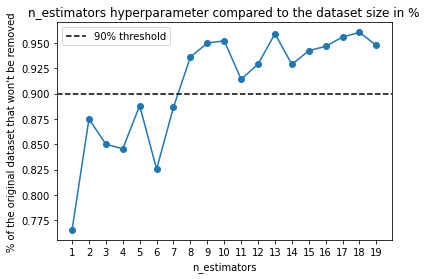

In [18]:
d = {}
for i in range(1, 20):
    lof = IsolationForest(n_estimators=i)
    X_out = lof.fit_predict(X)
    d[i] = np.sum(X_out == 1)/len(X_out)

plt.plot(list(d.keys()), list(d.values()), '-o')
plt.xticks(list(d.keys()))
plt.xlabel('n_estimators')
plt.ylabel('% of the original dataset that won\'t be removed')
plt.title('n_estimators hyperparameter compared to the dataset size in %')
plt.axhline(y=0.9, c='k', linestyle='dashed', label='90% threshold')
plt.legend()
plt.show()

In [19]:
lof = IsolationForest(n_estimators=6)
X_out = lof.fit_predict(X)
rows_to_drop = np.where(X_out == -1)[0]

In [20]:
df.drop(df.index[list(rows_to_drop)], inplace=True)
y.drop(y.index[list(rows_to_drop)], inplace=True)
df.reset_index(drop=True)
X = df

print(X.shape, y.shape, X_test.shape)

(2957, 171) (2957,) (1230, 171)


In [21]:
X.head()

,AST_AWAY,AST_HOME,AST_PCT_AWAY,AST_PCT_HOME,AST_RATIO_AWAY,AST_RATIO_HOME,AST_TOV_AWAY,AST_TOV_HOME,BLKA_AWAY,BLKA_HOME,...,UFGA_HOME,UFGM_AWAY,UFGM_HOME,UFG_PCT_AWAY,UFG_PCT_HOME,USG_PCT_AWAY,USG_PCT_HOME,NEXT_HOME,NEXT_AWAY,NEXT_WEIGHT
0,17,17,0.472,0.500,12.7,13.8,0.89,0.81,18,6,...,33,19,14,0.452,0.424,0.197,0.198,MIA,CHI,1.489674
1,23,26,0.657,0.703,17.0,19.9,1.21,1.30,7,4,...,44,18,26,0.375,0.591,0.198,0.196,LAL,LAC,5.361710
2,27,23,0.659,0.548,19.8,15.6,1.69,1.21,6,4,...,62,18,27,0.462,0.435,0.200,0.200,CLE,BKN,2.357026
3,24,21,0.727,0.600,18.2,15.7,1.60,1.50,3,8,...,40,20,21,0.426,0.525,0.200,0.195,PHI,MIA,5.980445
5,15,15,0.469,0.395,13.0,11.6,0.68,0.83,6,7,...,39,10,19,0.333,0.487,0.200,0.198,DET,WAS,1.721311


In [22]:
weights = X['NEXT_WEIGHT']
X = X.drop(columns=['NEXT_WEIGHT'])

X_test = X_test.drop(columns=['id'])

In [23]:
X.drop(columns=['TEAM_ID_AWAY', 'TEAM_ID_HOME'], inplace=True)
X_test.drop(columns=['TEAM_ID_AWAY', 'TEAM_ID_HOME'], inplace=True)
X.columns.tolist()

['AST_AWAY',
 'AST_HOME',
 'AST_PCT_AWAY',
 'AST_PCT_HOME',
 'AST_RATIO_AWAY',
 'AST_RATIO_HOME',
 'AST_TOV_AWAY',
 'AST_TOV_HOME',
 'BLKA_AWAY',
 'BLKA_HOME',
 'BLK_AWAY',
 'BLK_HOME',
 'CFGA_AWAY',
 'CFGA_HOME',
 'CFGM_AWAY',
 'CFGM_HOME',
 'CFG_PCT_AWAY',
 'CFG_PCT_HOME',
 'DEF_RATING_AWAY',
 'DEF_RATING_HOME',
 'DFGA_AWAY',
 'DFGA_HOME',
 'DFGM_AWAY',
 'DFGM_HOME',
 'DFG_PCT_AWAY',
 'DFG_PCT_HOME',
 'DIST_AWAY',
 'DIST_HOME',
 'DRBC_AWAY',
 'DRBC_HOME',
 'DREB_AWAY',
 'DREB_HOME',
 'DREB_PCT_AWAY',
 'DREB_PCT_HOME',
 'EFG_PCT_AWAY',
 'EFG_PCT_HOME',
 'FG3A_AWAY',
 'FG3A_HOME',
 'FG3M_AWAY',
 'FG3M_HOME',
 'FG3_PCT_AWAY',
 'FG3_PCT_HOME',
 'FGA_AWAY',
 'FGA_HOME',
 'FGM_AWAY',
 'FGM_HOME',
 'FG_PCT_AWAY',
 'FG_PCT_HOME',
 'FTAST_AWAY',
 'FTAST_HOME',
 'FTA_AWAY',
 'FTA_HOME',
 'FTA_RATE_AWAY',
 'FTA_RATE_HOME',
 'FTM_AWAY',
 'FTM_HOME',
 'FT_PCT_AWAY',
 'FT_PCT_HOME',
 'MIN_AWAY',
 'MIN_HOME',
 'NET_RATING_AWAY',
 'NET_RATING_HOME',
 'OFF_RATING_AWAY',
 'OFF_RATING_HOME',
 'OPP_EFG_

In [24]:
X.columns.tolist() == X_test.columns.tolist()

True

In [25]:
def define_features(df, df_test, y):
    data = {}

    # shifting makes calculating the features easier
#     y_tmp = y[:-1].reset_index(drop=True)
    df_tmp = df[1:].reset_index(drop=True)
    df_test_tmp = df_test[:]
    
    df_combined = pd.concat([df_tmp, df_test_tmp], ignore_index=True)
    
    home = 'TEAM_ABBREVIATION_HOME'
    away = 'TEAM_ABBREVIATION_AWAY'
    
#     data['HOME_WIN_PCT'] = []
#     data['AWAY_WIN_PCT'] = []
#     data['HOME_VS_AWAY_WIN_PCT'] = []
    
    cols = df_combined.select_dtypes(include=['number']).columns.tolist()
    for i in range(0, len(cols), 2):
        col_home, col_away = cols[i+1], cols[i]
        
        # all features are grouped as 'X_away', 'X_home' except for these 2
        if col_away == 'PTS_AWAY':
            col_home = 'PTS_HOME'
        elif col_away == 'PTS_FB_HOME':
            col_away = 'PTS_FB_AWAY'
            col_home = 'PTS_FB_HOME'
            
        data[f'{col_away}_AVG'] = []
        data[f'{col_home}_AVG'] = []
#         data[f'{col_away}_VS_HOME_AVG'] = []
#         data[f'{col_home}_VS_AWAY_AVG'] = []
    
    teams_playing = {}
    teams_playing['HOME'] = []
    teams_playing['AWAY'] = []
    
    for index, row in df_combined.iterrows():
        
        # data before the next game
        X_before = df_tmp.loc[:index-1, :]
#         y_before = y_tmp.loc[:index-1]
        
#         # percentage of games won by home team
#         numerator = X_before[((X_before[home] == row[home]) & (y_before == 1)) | \
#                              ((X_before[away] == row[home]) & (y_before == 0))]['AST_AWAY'].count()
#         denominator = X_before[(X_before[home] == row[home]) | (X_before[away] == row[home])]['AST_AWAY'].count()
#         data['HOME_WIN_PCT'].append(0 if numerator == 0 and denominator == 0 else  numerator/denominator)
        
        
#         # percentage of games won before by away team
#         numerator = X_before[((X_before[home] == row[away]) & (y_before == 1)) | \
#                              ((X_before[away] == row[away]) & (y_before == 0))]['AST_AWAY'].count()
#         denominator = X_before[(X_before[home] == row[away]) | (X_before[away] == row[away])]['AST_AWAY'].count()
#         data['AWAY_WIN_PCT'].append(0 if numerator == 0 and denominator == 0 else  numerator/denominator)
        
        
#         # percentage of games won that home team won against away team
#         numerator = X_before[((X_before[home] == row[away]) & (X_before[away] == row[home]) & (y_before == 0)) | \
#                              ((X_before[away] == row[away]) & (X_before[home] == row[home]) & (y_before == 1))]['AST_AWAY'].count()
#         denominator = X_before[((X_before[home] == row[away]) & (X_before[away] == row[home])) | \
#                              ((X_before[away] == row[away]) & (X_before[home] == row[home]))]['AST_AWAY'].count()
#         data['HOME_VS_AWAY_WIN_PCT'].append(0 if numerator == 0 and denominator == 0 else numerator/denominator)
        
        for i in range(0, len(cols), 2):
            col_home, col_away = cols[i+1], cols[i]

            if col_away == 'PTS_AWAY':
                col_home = 'PTS_HOME'
            elif col_away == 'PTS_FB_HOME':
                col_away = 'PTS_FB_AWAY'
                col_home = 'PTS_FB_HOME'
            
            data[f'{col_away}_AVG'].append(create_average_feature(X_before, row, col_home, col_away, away))
            data[f'{col_home}_AVG'].append(create_average_feature(X_before, row, col_home, col_away))
#             data[f'{col_away}_VS_HOME_AVG'].append(create_average_home_vs_away_feature(X_before, row, col_home, col_away, away, home))
#             data[f'{col_home}_VS_AWAY_AVG'].append(create_average_home_vs_away_feature(X_before, row, col_home, col_away))
            
        if index % 400 == 0:
            print(f'iteration {index}/{len(df_combined)}')        
        
        teams_playing['HOME'].append(row[home])
        teams_playing['AWAY'].append(row[away])
        
    return pd.DataFrame.from_dict(data), pd.DataFrame.from_dict(teams_playing)

def create_average_home_vs_away_feature(X_before, row, name_home, name_away, home='TEAM_ABBREVIATION_HOME', away='TEAM_ABBREVIATION_AWAY'):
    df_tmp1 = X_before[(X_before['TEAM_ABBREVIATION_HOME'] == row[away]) & (X_before['TEAM_ABBREVIATION_AWAY'] == row[home])][name_home]
    df_tmp2 = X_before[(X_before['TEAM_ABBREVIATION_AWAY'] == row[away]) & (X_before['TEAM_ABBREVIATION_HOME'] == row[home])][name_away]
    len1, len2, len1_and_len2 = len(df_tmp1), len(df_tmp2), len(df_tmp1) + len(df_tmp2)
    first = 0 if len1_and_len2 == 0 else (0 if pd.isna(df_tmp1.mean()) else df_tmp1.mean()) *(len1/len1_and_len2)
    second = 0 if len1_and_len2 == 0 else (0 if pd.isna(df_tmp2.mean()) else df_tmp2.mean()) *(len2/len1_and_len2)
    return first + second

def create_average_feature(X_before, row, name_home, name_away=None, curr='TEAM_ABBREVIATION_HOME'):
    df_tmp1 = X_before[(X_before['TEAM_ABBREVIATION_HOME'] == row[curr])][name_home]
    if name_away is None:
        return 0 if pd.isna(df_tmp1.mean()) else df_tmp1.mean()
    
    df_tmp2 = X_before[(X_before['TEAM_ABBREVIATION_AWAY'] == row[curr])][name_away]
    df_tmp3 = pd.concat([df_tmp1, df_tmp2], ignore_index=True)
    
    if len(df_tmp3) == 0:
        return 0
    
    
    mean_ = df_tmp3.mean()
    return 0 if pd.isna(mean_) else mean_

In [26]:
X_comb, teams_playing = define_features(X, X_test, y)

display(X_comb)

iteration 0/4186
iteration 400/4186
iteration 800/4186
iteration 1200/4186
iteration 1600/4186
iteration 2000/4186
iteration 2400/4186
iteration 2800/4186
iteration 3200/4186
iteration 3600/4186
iteration 4000/4186


,AST_AWAY_AVG,AST_HOME_AVG,AST_PCT_AWAY_AVG,AST_PCT_HOME_AVG,AST_RATIO_AWAY_AVG,AST_RATIO_HOME_AVG,AST_TOV_AWAY_AVG,AST_TOV_HOME_AVG,BLKA_AWAY_AVG,BLKA_HOME_AVG,...,TS_PCT_AWAY_AVG,TS_PCT_HOME_AVG,UFGA_AWAY_AVG,UFGA_HOME_AVG,UFGM_AWAY_AVG,UFGM_HOME_AVG,UFG_PCT_AWAY_AVG,UFG_PCT_HOME_AVG,USG_PCT_AWAY_AVG,USG_PCT_HOME_AVG
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4181,25.201835,21.224390,0.665009,0.572961,19.026606,16.450244,1.817523,1.578293,4.756881,4.570732,...,0.555009,0.534727,48.614679,44.917073,21.770642,19.614634,0.448317,0.437005,0.198711,0.198839
4182,24.352381,19.666667,0.617000,0.556421,18.630952,15.715897,1.938095,1.368718,4.257143,4.846154,...,0.560629,0.531492,46.361905,43.589744,21.161905,18.394872,0.456690,0.423785,0.199095,0.198333
4183,21.229167,23.923077,0.561266,0.618753,16.027604,18.169780,1.454583,1.905440,5.619792,3.258242,...,0.539760,0.559637,43.203125,50.126374,19.401042,22.818681,0.446911,0.455280,0.198771,0.198863
4184,21.298913,25.968586,0.575016,0.638094,16.209783,18.985864,1.613152,1.887330,4.798913,3.958115,...,0.522293,0.568199,45.005435,47.340314,19.076087,22.041885,0.424663,0.463037,0.198951,0.199377


In [27]:
X1 = X_comb.iloc[1:len(X)]
y1 = y[:-1]
X2 = X_comb.iloc[-len(X_test):]

print(X1.shape, y1.shape, X2.shape)

(2956, 164) (2956,) (1230, 164)


## 2. Cross-validation function

In [28]:
from wittgenstein import RIPPER
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import TimeSeriesSplit, KFold
from sklearn.metrics import accuracy_score

In [29]:
import warnings
warnings.filterwarnings('ignore') 

def cross_validation(X, y):
    d = {'Algorithm': [], 'Fold 1': [], 'Fold 2': [],'Fold 3': [], 'Fold 4': [], 'Fold 5': [], 'Average': []}
    algs = [GaussianNB, LogisticRegression, RandomForestClassifier, ExtraTreesClassifier, XGBClassifier]#, RIPPER]
    d['Algorithm'] = algs
    
    kf = TimeSeriesSplit()
    splits = [i for i in kf.split(X)]
    for i, (train_index, test_index) in enumerate(splits):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
        fold_acc = []
        for curr_alg in algs:
            alg = curr_alg()
            alg.fit(X_train, y_train)
            y_pred = alg.predict(X_test)
            acc = accuracy_score(y_pred, y_test)
            fold_acc.append(acc)
        d[f'Fold {i+1}'] = fold_acc
    
    tmp = np.array([d[c] for c in list(d.keys())[1:-1]])
    d['Average'] = np.average(tmp, axis=0).tolist()
    
    res_df = pd.DataFrame.from_dict(d)
    display(res_df)

## 3. Run the cross validation function

Unfortunately I didn't have enough submits to submit to the public leaderboard.

In [30]:
y1 = y1.map(lambda x: 1 if x == 1 else 0).reset_index(drop=True)

In [31]:
# first ~300 rows have very poor feature values
X = X1[300:]
y = y1[300:]

In [32]:
cross_validation(X, y)

,Algorithm,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Average
0,<class 'sklearn.naive_bayes.GaussianNB'>,0.479638,0.509050,0.466063,0.509050,0.520362,0.496833
1,<class 'sklearn.linear_model._logistic.Logisti...,0.500000,0.511312,0.536199,0.561086,0.565611,0.534842
2,<class 'sklearn.ensemble._forest.RandomForestC...,0.540724,0.545249,0.540724,0.574661,0.563348,0.552941
3,<class 'sklearn.ensemble._forest.ExtraTreesCla...,0.518100,0.500000,0.527149,0.531674,0.536199,0.522624
4,<class 'xgboost.sklearn.XGBClassifier'>,0.533937,0.522624,0.529412,0.556561,0.547511,0.538009


## 4. Correlations

In [33]:
X_corr = X.corr()

def plot_corr_matrix(X_corr, size, annot=False):
    fig = plt.figure(figsize=size)

    sb.heatmap(
        X_corr,
        annot=annot,
        linewidths=.5,
    )

    plt.title('Correlation matrix')

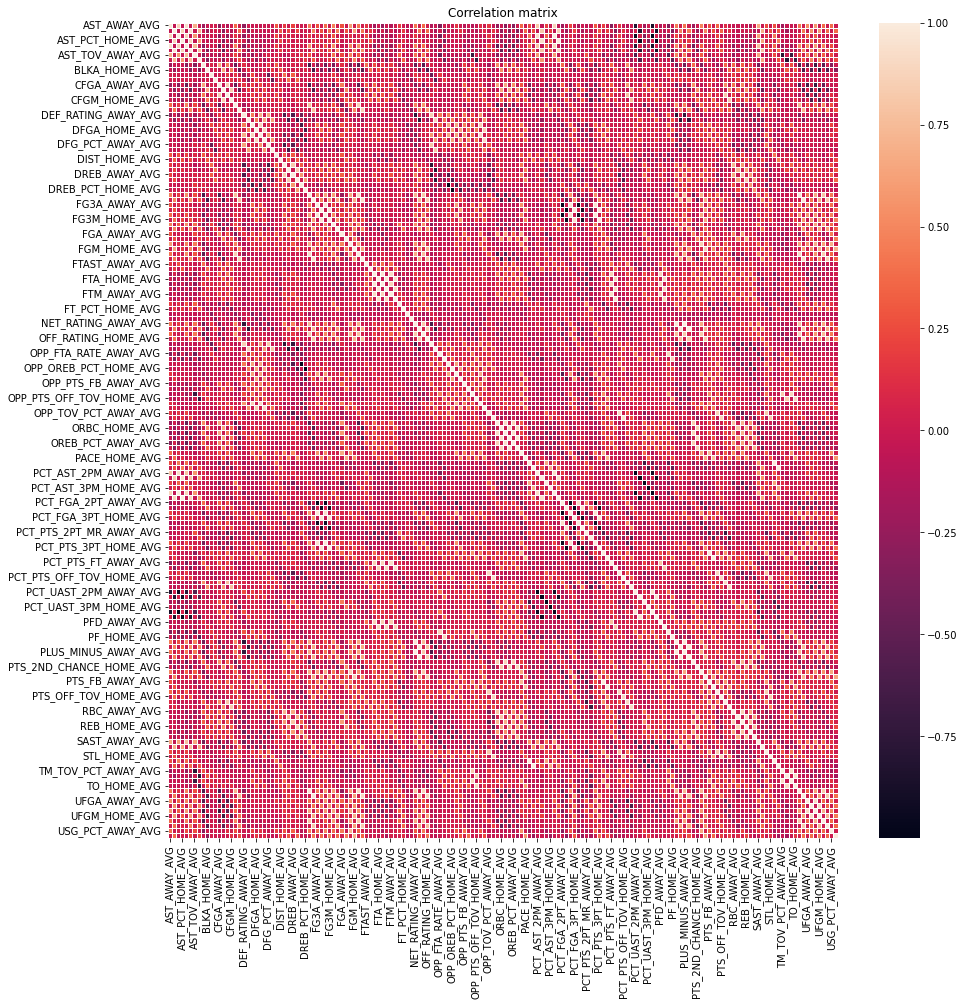

In [34]:
plot_corr_matrix(X_corr, (15, 15))

In [35]:
# remove everythin above .7

columns = np.full((X_corr.shape[0],), True, dtype=bool)
for i in range(X_corr.shape[0]):
    for j in range(i+1, X_corr.shape[0]):
        if np.abs(X_corr.iloc[i,j]) >= 0.7:
            if columns[j]:
                columns[j] = False
selected_columns = X.columns[columns]

X = X[selected_columns]
X2 = X2[selected_columns]

selected_columns

Index(['AST_AWAY_AVG', 'AST_HOME_AVG', 'BLKA_AWAY_AVG', 'BLKA_HOME_AVG',
       'BLK_AWAY_AVG', 'BLK_HOME_AVG', 'CFGA_AWAY_AVG', 'CFGA_HOME_AVG',
       'CFG_PCT_AWAY_AVG', 'CFG_PCT_HOME_AVG', 'DEF_RATING_AWAY_AVG',
       'DEF_RATING_HOME_AVG', 'DFGA_AWAY_AVG', 'DFGA_HOME_AVG',
       'DFG_PCT_AWAY_AVG', 'DFG_PCT_HOME_AVG', 'DIST_AWAY_AVG',
       'DIST_HOME_AVG', 'DRBC_AWAY_AVG', 'DRBC_HOME_AVG', 'DREB_PCT_AWAY_AVG',
       'DREB_PCT_HOME_AVG', 'FG3A_AWAY_AVG', 'FG3A_HOME_AVG',
       'FG3_PCT_AWAY_AVG', 'FG3_PCT_HOME_AVG', 'FGA_AWAY_AVG', 'FGA_HOME_AVG',
       'FGM_AWAY_AVG', 'FGM_HOME_AVG', 'FTAST_AWAY_AVG', 'FTAST_HOME_AVG',
       'FTA_AWAY_AVG', 'FTA_HOME_AVG', 'FT_PCT_AWAY_AVG', 'FT_PCT_HOME_AVG',
       'MIN_AWAY_AVG', 'MIN_HOME_AVG', 'OPP_FTA_RATE_AWAY_AVG',
       'OPP_FTA_RATE_HOME_AVG', 'OPP_PTS_2ND_CHANCE_AWAY_AVG',
       'OPP_PTS_2ND_CHANCE_HOME_AVG', 'OPP_PTS_FB_AWAY_AVG',
       'OPP_PTS_FB_HOME_AVG', 'OPP_PTS_OFF_TOV_HOME_AVG',
       'OPP_TOV_PCT_AWAY_AVG', 'OPP_TO

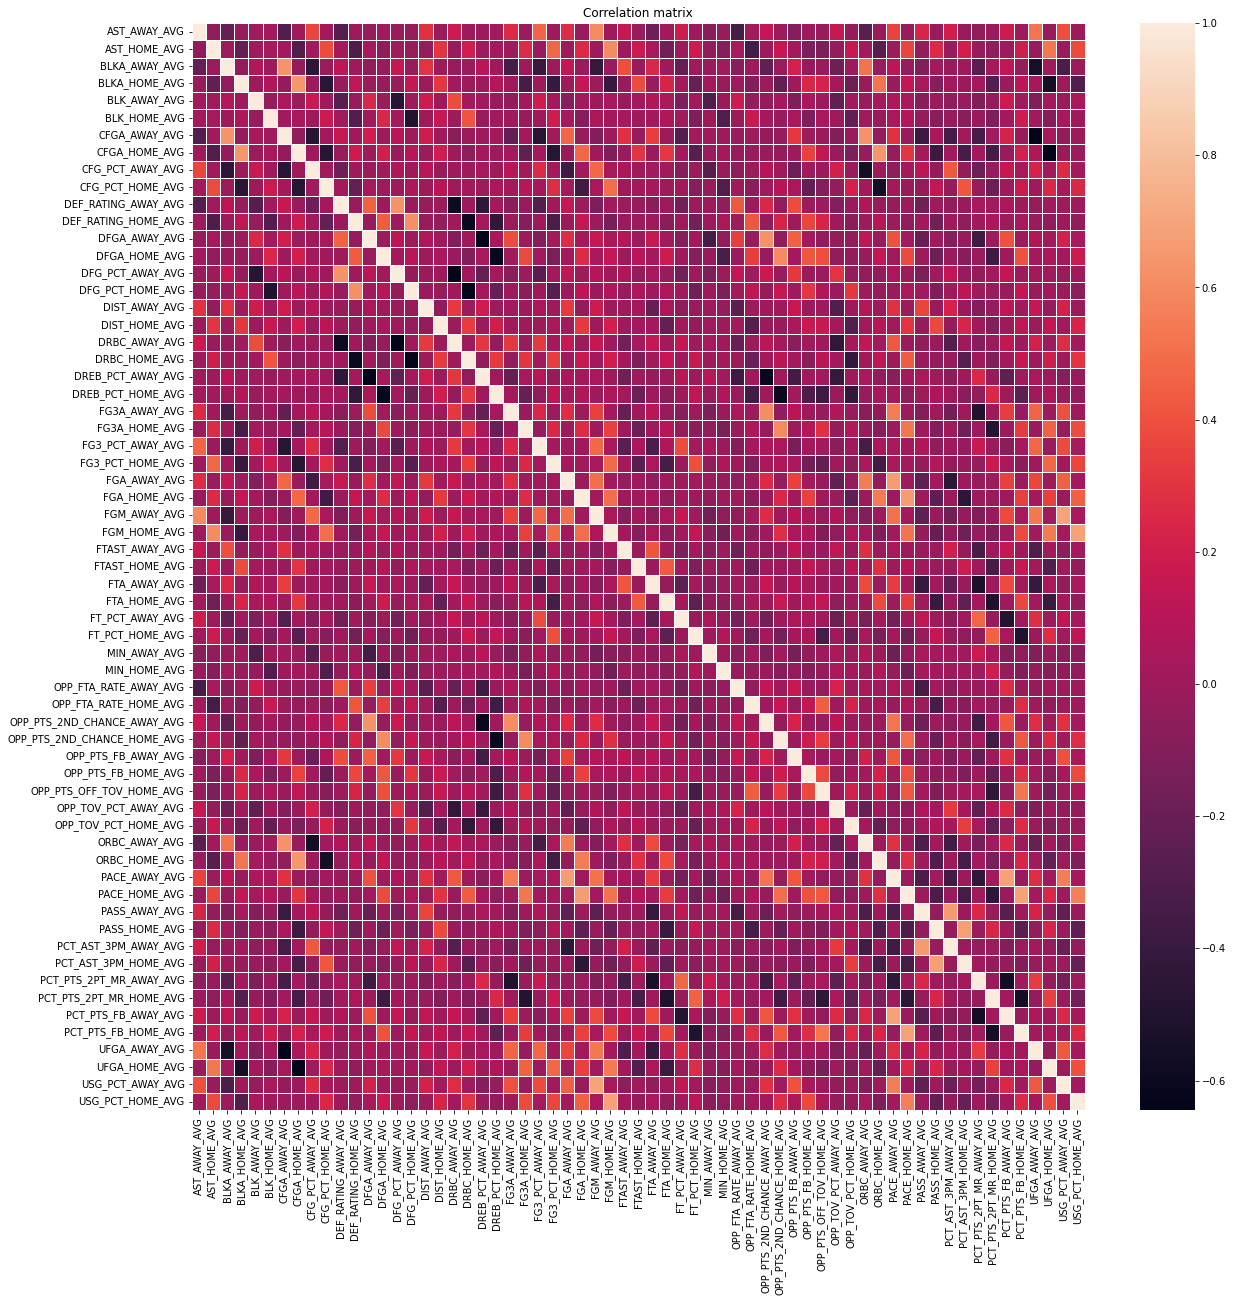

In [36]:
X_corr = X.corr()
plot_corr_matrix(X_corr, (20, 20))

## 5. New features

* FGA_HOME_AVG_OVER_FGA_SUM 

The ratio of home field goal attempts and the sum of home and away field goal attempts. It makes sense that this ratio would be bigger than 0.5 if the home team is better, otherwise it would be less than 0.5.

* AST_AVG_DIFF_TIMES_BLK_RATIO 

The difference of the assist averages multiplied by the block ratio. If the ratio is high and the difference is high then the value of this variable would be positive which means that the home team is better, otherwise the value would be negative which means the away team is better.

* DEF_RATING_BLK_HOME_SUM_EXP_MINUS_DEF_RATING_BLK_AWAY_SUM_EXP

The difference between the sums of the defensive rating average and the block home average to the 1.1 power. If the value is positive it means that the first team is better otherwise the away team is better. The 1.1 power is used to add nonlinearity.


In [37]:
X['FGA_HOME_AVG_OVER_FGA_SUM'] = X['FGA_HOME_AVG']/(X['FGA_AWAY_AVG'] + X['FGA_HOME_AVG'])

X['AST_AVG_DIFF_TIMES_BLK_RATIO'] = (X['AST_HOME_AVG'] - X['AST_AWAY_AVG'])*(X['BLK_HOME_AVG'] / X['BLK_AWAY_AVG'])
X['AST_AVG_DIFF_TIMES_BLK_RATIO'].fillna(0)

X['DEF_RATING_BLK_HOME_SUM_EXP_MINUS_DEF_RATING_BLK_AWAY_SUM_EXP'] = ((X['DEF_RATING_HOME_AVG'] + X['BLK_HOME_AVG'])**1.1 - \
                                                                  (X['DEF_RATING_AWAY_AVG'] + X['BLK_AWAY_AVG'])**1.1)



X2['FGA_HOME_AVG_OVER_FGA_SUM'] = X2['FGA_HOME_AVG']/(X2['FGA_AWAY_AVG'] + X2['FGA_HOME_AVG'])

X2['AST_AVG_DIFF_TIMES_BLK_RATIO'] = (X2['AST_HOME_AVG'] - X2['AST_AWAY_AVG'])*(X2['BLK_HOME_AVG'] / X2['BLK_AWAY_AVG'])
X2['AST_AVG_DIFF_TIMES_BLK_RATIO'].fillna(0)

X2['DEF_RATING_BLK_HOME_SUM_EXP_MINUS_DEF_RATING_BLK_AWAY_SUM_EXP'] = ((X2['DEF_RATING_HOME_AVG'] + X2['BLK_HOME_AVG'])**1.1 - \
                                                                  (X2['DEF_RATING_AWAY_AVG'] + X2['BLK_AWAY_AVG'])**1.1)


In [38]:
# check for na's in all columns
for c in X.columns.tolist():
    tmp = X[X[c].isna()]
    if len(tmp) != 0:
        print(c)
        print(len(tmp))
        print('-------')

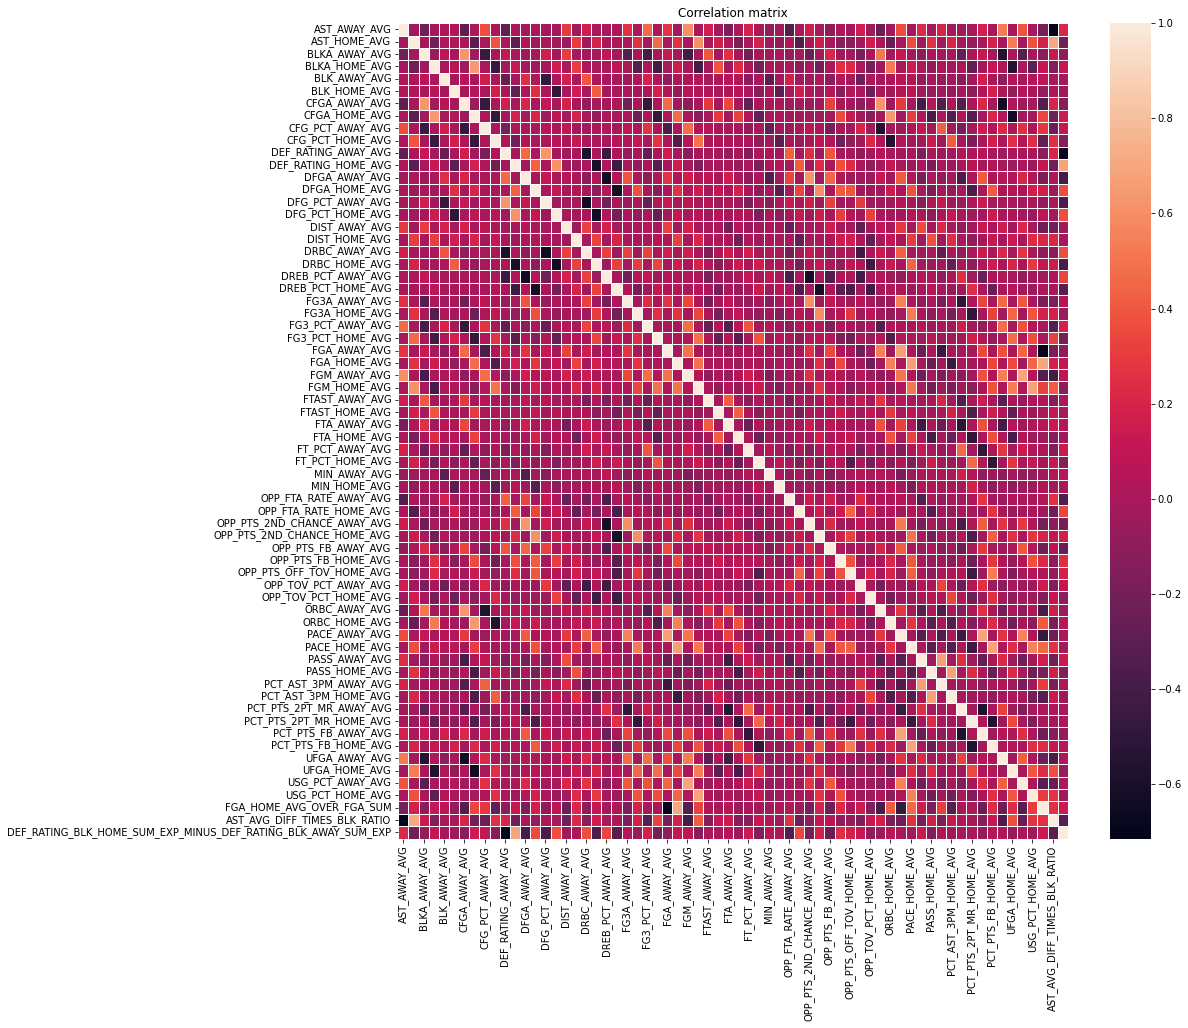

In [39]:
X_corr = X.corr()
plot_corr_matrix(X_corr, (15, 15))

## 6. Run the cross-validation function 

The cross validation function gives results that are a bit better after adding the new features.

In [40]:
cross_validation(X, y)

,Algorithm,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Average
0,<class 'sklearn.naive_bayes.GaussianNB'>,0.500000,0.509050,0.488688,0.542986,0.545249,0.517195
1,<class 'sklearn.linear_model._logistic.Logisti...,0.513575,0.497738,0.531674,0.545249,0.579186,0.533484
2,<class 'sklearn.ensemble._forest.RandomForestC...,0.511312,0.520362,0.536199,0.567873,0.581448,0.543439
3,<class 'sklearn.ensemble._forest.ExtraTreesCla...,0.511312,0.509050,0.538462,0.542986,0.567873,0.533937
4,<class 'xgboost.sklearn.XGBClassifier'>,0.518100,0.518100,0.524887,0.567873,0.533937,0.532579


## 7. Filter method

The optimal number of features depends on the random seed but usually it's 15.

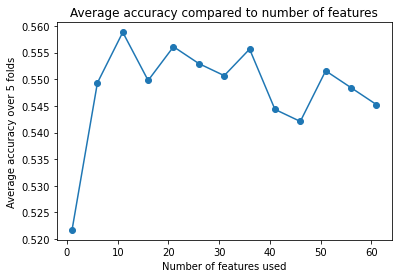

In [41]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest, RFE
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

k = 1
final_d = {}
for k in range(1, X.shape[1], 5):   
    sel = SelectKBest(score_func=mutual_info_classif, k=k)
    X_tmp = sel.fit_transform(X, y)
        
    d = {}
    kf = TimeSeriesSplit()
    for i, (train_index, test_index) in enumerate(kf.split(X_tmp)):
        
        X_train, X_test = X_tmp[train_index], X_tmp[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        pipeline = Pipeline(steps=[
            ('scaler', StandardScaler()), 
            ('lr', RandomForestClassifier())
        ])
            
        fold_acc = []
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        acc = accuracy_score(y_pred, y_test)
        fold_acc.append(acc)
        d[f'Fold {i+1}'] = fold_acc
    
    tmp = np.array([d[c] for c in list(d.keys())[:]])
    d['Average'] = np.average(tmp, axis=0).tolist()
    
    final_d[k] = d['Average'][:]

plt.plot(list(final_d.keys()), list(final_d.values()), 'o-')
plt.xlabel('Number of features used')
plt.ylabel('Average accuracy over 5 folds')
plt.title('Average accuracy compared to number of features')
plt.show()

## 8. Run the cross-validation function 

I'll try the cross validation function using 15 features. Some models perform a bit better while others perform a bit worse.

In [42]:
skb = SelectKBest(score_func=mutual_info_classif, k=15).fit(X, y)
feature_names = skb.get_feature_names_out() 
X_tmp = X[feature_names]

X_tmp

,BLKA_AWAY_AVG,DFGA_HOME_AVG,DIST_AWAY_AVG,DREB_PCT_AWAY_AVG,FTAST_HOME_AVG,FTA_AWAY_AVG,OPP_FTA_RATE_AWAY_AVG,OPP_PTS_2ND_CHANCE_HOME_AVG,OPP_PTS_OFF_TOV_HOME_AVG,OPP_TOV_PCT_HOME_AVG,PACE_AWAY_AVG,PACE_HOME_AVG,PASS_AWAY_AVG,UFGA_HOME_AVG,USG_PCT_HOME_AVG
301,5.571429,19.944444,17.169524,0.716476,1.111111,22.714286,0.327524,11.333333,16.833333,0.143056,94.293810,97.235000,330.857143,46.888889,0.198889
302,5.450000,21.650000,16.958500,0.774300,1.150000,25.500000,0.282500,12.350000,18.100000,0.165550,94.417000,95.140000,326.700000,36.550000,0.198350
303,6.181818,21.625000,16.170000,0.757091,1.750000,24.318182,0.311682,13.750000,15.416667,0.154208,96.586818,97.173333,264.727273,47.333333,0.199125
304,4.684211,23.217391,16.588947,0.748105,1.304348,24.421053,0.282895,14.913043,18.086957,0.150087,95.714211,94.553913,259.157895,41.695652,0.197826
305,4.050000,23.000000,17.253500,0.748400,1.842105,21.050000,0.265300,13.789474,15.578947,0.146368,95.174000,93.816842,315.800000,39.052632,0.199000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2952,5.701923,24.397959,16.926250,0.764702,1.877551,22.451923,0.295885,13.535714,16.693878,0.157158,95.661538,97.801531,275.591346,41.954082,0.198765
2953,5.097087,22.705263,16.616165,0.754359,1.563158,22.257282,0.278194,13.578947,16.231579,0.150863,93.986602,99.809632,304.446602,47.252632,0.199374
2954,3.248619,24.927083,16.506906,0.749735,1.343750,25.701657,0.291160,13.812500,17.817708,0.151995,97.560884,98.867396,292.801105,46.536458,0.198958
2955,6.021390,23.535000,16.804439,0.759840,1.430000,24.438503,0.301198,13.090000,15.695000,0.127250,98.965829,97.345200,271.128342,49.120000,0.199280


In [43]:
cross_validation(X_tmp, y)

,Algorithm,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Average
0,<class 'sklearn.naive_bayes.GaussianNB'>,0.527149,0.520362,0.552036,0.581448,0.572398,0.550679
1,<class 'sklearn.linear_model._logistic.Logisti...,0.529412,0.524887,0.588235,0.590498,0.579186,0.562443
2,<class 'sklearn.ensemble._forest.RandomForestC...,0.567873,0.524887,0.572398,0.585973,0.581448,0.566516
3,<class 'sklearn.ensemble._forest.ExtraTreesCla...,0.542986,0.515837,0.576923,0.579186,0.581448,0.559276
4,<class 'xgboost.sklearn.XGBClassifier'>,0.545249,0.524887,0.549774,0.583710,0.604072,0.561538


## 9. Explainability with SHAP

In [44]:
import shap

pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()), 
    ('efc', ExtraTreesClassifier())
])
            
pipeline.fit(X_tmp, y)

Pipeline(steps=[('scaler', StandardScaler()), ('efc', ExtraTreesClassifier())])

In [45]:
teams_playing_train = teams_playing[1:len(X)]
teams_playing_train

,HOME,AWAY
1,LAL,LAC
2,CLE,BKN
3,TOR,BOS
4,DET,WAS
5,NYK,MIL
...,...,...
2651,DAL,OKC
2652,LAC,DEN
2653,SAC,SAS
2654,BOS,MIL


In [46]:
print(np.where((teams_playing_train['HOME'] == 'LAL') | (teams_playing_train['AWAY'] == 'LAL'))[0][-10:])

[2451 2464 2469 2517 2528 2537 2570 2583 2591 2634]


In [47]:
X_tmp_lal = X_tmp.iloc[np.where((teams_playing_train['HOME'] == 'LAL') | (teams_playing_train['AWAY'] == 'LAL'))[0][-10:]]
X_tmp_lal

,BLKA_AWAY_AVG,DFGA_HOME_AVG,DIST_AWAY_AVG,DREB_PCT_AWAY_AVG,FTAST_HOME_AVG,FTA_AWAY_AVG,OPP_FTA_RATE_AWAY_AVG,OPP_PTS_2ND_CHANCE_HOME_AVG,OPP_PTS_OFF_TOV_HOME_AVG,OPP_TOV_PCT_HOME_AVG,PACE_AWAY_AVG,PACE_HOME_AVG,PASS_AWAY_AVG,UFGA_HOME_AVG,USG_PCT_HOME_AVG
2752,4.875000,22.531429,17.042174,0.760440,1.628571,23.152174,0.288326,12.794286,17.891429,0.141011,93.560326,98.442057,340.619565,42.605714,0.198794
2765,5.625000,25.103448,16.772386,0.756364,1.178161,26.897727,0.284386,13.867816,16.643678,0.135379,98.425114,98.298276,272.863636,44.988506,0.198943
2770,5.497297,21.218274,16.677838,0.743492,1.675127,26.281081,0.252870,11.730964,14.878173,0.161680,97.858541,93.940508,282.021622,43.025381,0.198812
2818,5.829016,23.219101,16.997047,0.753404,1.202247,22.647668,0.244083,12.544944,16.449438,0.143478,95.444611,94.250730,305.497409,46.606742,0.198500
2829,4.752577,24.156566,16.490412,0.754649,1.626263,25.278351,0.289753,12.186869,15.065657,0.138687,95.081649,95.641010,286.587629,43.767677,0.198783
2838,5.800000,22.666667,17.484235,0.745424,1.551913,23.270588,0.316082,13.590164,16.098361,0.151481,99.640647,99.831475,314.111765,47.245902,0.199372
2871,5.507853,23.484211,16.688377,0.742277,1.826316,26.366492,0.251874,12.021053,17.200000,0.141158,97.888796,93.496684,281.659686,43.600000,0.198332
2884,4.118483,22.282486,16.825261,0.769479,1.480226,21.436019,0.282265,13.129944,15.553672,0.152181,97.079668,97.620904,300.369668,50.079096,0.198876
2892,4.946237,23.120603,17.046290,0.791538,1.256281,22.774194,0.248704,12.879397,15.653266,0.150965,95.976183,95.057487,304.397849,40.703518,0.198352
2935,5.780000,24.004831,16.990150,0.753055,1.632850,22.550000,0.244500,12.169082,15.135266,0.138821,95.464450,95.677391,305.195000,43.879227,0.198797


In [48]:
shap.initjs()
explainer = shap.TreeExplainer(pipeline['efc'])
shap_values = explainer.shap_values(X_tmp_lal)
shap.force_plot(explainer.expected_value[0], shap_values[0])

In [49]:
shap_values[0]

array([[ 0.06386558,  0.00212095, -0.01014371,  0.00790396, -0.00233493,
        -0.01885663,  0.00717706,  0.02020552, -0.00491539,  0.00132171,
        -0.00900456,  0.00527756, -0.00070779,  0.02227071,  0.01223561],
       [ 0.06307378,  0.00212939, -0.00900324,  0.00925459,  0.00296596,
        -0.01810174,  0.00770994,  0.02456716, -0.00487749,  0.00041603,
        -0.01337193,  0.00486895,  0.00165052,  0.02358796,  0.01154579],
       [ 0.06349083,  0.00200134, -0.00992134,  0.00837894, -0.00260277,
        -0.0188597 ,  0.00688682,  0.0201287 , -0.00526838,  0.00174596,
        -0.00912477,  0.00528067, -0.00062549,  0.02257299,  0.01233187],
       [ 0.06314649,  0.00194395, -0.00902895,  0.00946099,  0.00274665,
        -0.01868555,  0.00748544,  0.02739114, -0.00500429,  0.00047966,
        -0.01441545,  0.00505365,  0.00331999,  0.02285466,  0.00966725],
       [ 0.0638551 ,  0.00214189, -0.01009068,  0.00797792, -0.00227548,
        -0.01886093,  0.00724183,  0.0201962 , 

In [50]:
 X.iloc[np.where((teams_playing_train['HOME'] == 'LAL') | (teams_playing_train['AWAY'] == 'LAL'))[0][-10:]]

,AST_AWAY_AVG,AST_HOME_AVG,BLKA_AWAY_AVG,BLKA_HOME_AVG,BLK_AWAY_AVG,BLK_HOME_AVG,CFGA_AWAY_AVG,CFGA_HOME_AVG,CFG_PCT_AWAY_AVG,CFG_PCT_HOME_AVG,...,PCT_PTS_2PT_MR_HOME_AVG,PCT_PTS_FB_AWAY_AVG,PCT_PTS_FB_HOME_AVG,UFGA_AWAY_AVG,UFGA_HOME_AVG,USG_PCT_AWAY_AVG,USG_PCT_HOME_AVG,FGA_HOME_AVG_OVER_FGA_SUM,AST_AVG_DIFF_TIMES_BLK_RATIO,DEF_RATING_BLK_HOME_SUM_EXP_MINUS_DEF_RATING_BLK_AWAY_SUM_EXP
2752,19.657609,21.000000,4.875000,5.640000,5.331522,3.994286,36.320652,39.497143,0.474011,0.456469,...,0.168423,0.118989,0.144040,43.440217,42.605714,0.198321,0.198794,0.508933,1.005697,-0.747701
2765,21.022727,21.488506,5.625000,4.793103,4.000000,4.724138,39.454545,40.183908,0.456716,0.451408,...,0.188207,0.144085,0.135408,42.642045,44.988506,0.198778,0.198943,0.507522,0.550100,4.518926
2770,22.518919,21.624365,5.497297,4.989848,4.037838,4.390863,41.562162,38.812183,0.456297,0.475299,...,0.189614,0.134605,0.117447,41.967568,43.025381,0.198784,0.198812,0.493476,-0.972764,-7.679100
2818,22.243523,20.522472,5.829016,3.938202,5.544041,4.674157,39.238342,35.292135,0.444922,0.441635,...,0.234157,0.106591,0.091938,43.725389,46.606742,0.198528,0.198500,0.497744,-1.451011,9.298846
2829,19.948454,21.505051,4.752577,5.686869,4.551546,5.575758,40.118557,39.646465,0.457845,0.466848,...,0.177288,0.106010,0.119955,40.639175,43.767677,0.198330,0.198783,0.505465,1.906870,7.666386
2838,21.211765,25.901639,5.800000,3.994536,5.494118,5.491803,40.500000,38.207650,0.451306,0.477574,...,0.149038,0.150841,0.165634,43.100000,47.245902,0.198653,0.199372,0.507099,4.687899,-5.991642
2871,22.643979,19.694737,5.507853,4.894737,4.057592,5.305263,41.476440,36.226316,0.457639,0.473826,...,0.161005,0.134927,0.117974,42.015707,43.600000,0.198775,0.198332,0.487309,-3.856107,-0.749400
2884,23.639810,23.875706,4.118483,3.288136,4.379147,5.129944,35.194313,32.412429,0.485095,0.491136,...,0.194006,0.159995,0.137040,48.303318,50.079096,0.198924,0.198876,0.495812,0.276340,0.670573
2892,21.225806,19.964824,4.946237,4.758794,5.139785,4.603015,38.688172,40.020101,0.453935,0.458382,...,0.151784,0.107651,0.106261,44.284946,40.703518,0.198527,0.198352,0.494545,-1.129293,1.435583
2935,22.190000,21.613527,5.780000,5.714976,5.580000,5.449275,39.100000,39.483092,0.443850,0.466986,...,0.177831,0.106025,0.120734,43.885000,43.879227,0.198500,0.198797,0.500948,-0.562968,10.251315


SHAP values are a 2d array that contains the "weights" for how much each feature affects the prediction of the model. If the weight is positive the feature has a positive impact on the prediction and if the weight is negative, the impact on the prediction is negative.

Most features are equally as important, maybe feature 7 sticks out.

These features might not be the best possible features because SelectKBest doesn't guarantee the best possible solution. Some other features can show a substantial difference between the teams.

## 10. RIPPER optimization

In [51]:
def train_test_ripper(max_rules=10000, max_rule_conds=10000, d={'k':2, 'prune_size':0.33, 'dl_allowance':64}):
    np.random.seed(42)
    last_train_index = int(0.67*len(X_tmp))

    X_train, X_test = X_tmp.iloc[0:last_train_index], X_tmp.iloc[last_train_index:]
    y_train, y_test = y.iloc[0:last_train_index], y.iloc[last_train_index:]
    
    print(f'Hyperparameters used are: k={d["k"]}, prune_size={d["prune_size"]}, dl_allowance={d["dl_allowance"]}\n')
    pipeline = Pipeline(steps=[
        ('scaler', StandardScaler()), 
        ('ripper', RIPPER(k=d['k'], prune_size=d['prune_size'], dl_allowance=d['dl_allowance'], max_rules=max_rules, max_rule_conds=max_rule_conds))
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    acc = accuracy_score(y_pred, y_test)
    print(f'Accuracy on the test set is: {acc}')

    pipeline['ripper'].out_model()
    
train_test_ripper()

Hyperparameters used are: k=2, prune_size=0.33, dl_allowance=64

Accuracy on the test set is: 0.580387685290764
[[2=-0.13-0.1 ^ 8=-1.14--0.79] V
[13=<-1.25 ^ 7=0.8-1.29]]


Unfortunately it's hard to interpret the rules because they change each time the program is run but the main idea is if the statement: [[if the zeroth feature is between x11 and y11 and the first feature is between x21 and y21 ...] or [if the zeroth feature is between x12 and y12 and the first feature is between x22 and y22 ...]] holds then the prediction will be 1 otherwise 0. I hardcoded the seed but the results are different every time.

    Parameters
    ----------
    k : int, default=2
        Number of RIPPERk optimization iterations.

    prune_size : float, default=.33
        Proportion of training set to be used for pruning.

    dl_allowance : int, default=64
        Terminate Ruleset grow phase early if a Ruleset description length is encountered
        that is more than this amount above the lowest description length so far encountered.

In [52]:
from sklearn.model_selection import GridSearchCV

kf = TimeSeriesSplit(n_splits=5)
splits = kf.split(X_tmp)

pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()), 
    ('ripper', RIPPER())
])

grid_params = {
    'ripper__k': list(range(2, 10)),
    'ripper__prune_size': [0.3, 0.4, 0.5, 0.6],
    'ripper__dl_allowance': [8, 12, 16, 24, 32, 48],
}

search = GridSearchCV(pipeline, grid_params, cv=splits, verbose=1)
search.fit(X_tmp, y)

bp1 = search.best_params_

print(search.best_score_)
print(search.best_params_)

Fitting 5 folds for each of 192 candidates, totalling 960 fits
0.5900452488687783
{'ripper__dl_allowance': 8, 'ripper__k': 7, 'ripper__prune_size': 0.4}


If we change the values of max_rules to 3 and max_rule_conds to 2 the rules usually get simpler (shorter clauses, less clauses), but the random seed also has an effect. If the base models' rules were more complex and longer then we would easily see a difference.

In [53]:
train_test_ripper(d={k.split('ripper__')[1]:v for k,v in bp1.items()})

Hyperparameters used are: k=7, prune_size=0.4, dl_allowance=8

Accuracy on the test set is: 0.5895096921322691
[[11=-0.95--0.62 ^ 13=<-1.25 ^ 14=-0.91--0.56]]


In [54]:
train_test_ripper(d={k.split('ripper__')[1]:v for k,v in bp1.items()}, max_rules=3, max_rule_conds=2)

Hyperparameters used are: k=7, prune_size=0.4, dl_allowance=8

Accuracy on the test set is: 0.5895096921322691
[[13=<-1.25 ^ 7=0.8-1.29]]


The RIPPER algorithm performs okay compared to the other classifiers.

Some advantages of the RIPPER algorithm are that we can easily see why the model predicted a certain label by printing the ruleset, it works well with imbalanced classes and it isn't prone to overfitting. 

The drawbacks are that it's slower than some other often used algorithms, it doesn't work that well with continuous features and some other algorithms might outperform this one (it depends on the problem at hand).

(Advantages and drawbacks can be found here: https://towardsdatascience.com/how-to-perform-explainable-machine-learning-classification-without-any-trees-873db4192c68)